In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import os
import pyNBS as nbs
import glob

# Preprocess data

In [3]:
# Some old code...

dirs=["survival","network"]
for d in dirs:
    if not os.path.exists(d):
        os.makedirs(d)

DIR4NBS="/cellar/data/users/wzhang1984/forNBS/"

id2gene={}
maxid=0
for line in open(DIR4NBS+"Homo_sapiens.gene_info").read().rstrip().split("\n")[1:]:
    a=line.split("\t")
    id2gene[a[1]]=a[2]
    maxid=max(maxid,int(a[1]))

gene2id={}
for line in open(DIR4NBS+"gene2id.txt").read().rstrip().split("\n"):
    a=line.split("\t")
    gene2id[a[0]]=a[1]


id2hallmark={}
for line in open(DIR4NBS+"hallmarks.txt").read().rstrip().split("\n"):
    a=line.split("\t")
    if len(a)>1:
        for ID in a[2:]:
            if not ID in id2hallmark:
                id2hallmark[ID]={}
            id2hallmark[ID][a[0].split("|")[1]]=1

for line in open(DIR4NBS+"oncogene_tsg.txt").read().rstrip().split("\n"):
    a=line.split("\t")
    if a[0] in gene2id:
        ID=gene2id[a[0]]
        if ID not in id2hallmark:
            id2hallmark[ID]={}
        id2hallmark[ID][a[1]]=1

rearrangements_fns=glob.glob(DIR4NBS+"rearrangements_*.txt")
for fn in rearrangements_fns:
    for line in open(fn).read().rstrip().split("\n"):
        a=line.split("\t")
        anno=fn.split("/")[-1].split(".")[0]
        g_list=a[0].split(",")
        g_list.extend(a[1].split(","))
        for g in g_list:
            if g in gene2id:
                ID=gene2id[g]
                if ID not in id2hallmark:
                    id2hallmark[ID]={}
                id2hallmark[ID][anno]=1

for line in open(DIR4NBS+"cancerPredispositionGenes.txt").read().rstrip().split("\n"):
    a=line.split("\t")
    if a[0] in gene2id:
        ID=gene2id[a[0]]
        if ID not in id2hallmark:
            id2hallmark[ID]={}
        id2hallmark[ID]["predisposition"]=1

whitelist=set()
for line in open('../rnaseq_eQTL_merge50_c35/whitelist.txt').read().rstrip().split('\n'):
    [gene,gid]=line.split('|')
    whitelist.add(gene)

pat2mut={}
pat2mut_source={}
gene2score={}
gene2og_tsg={}
for line in open('../rnaseq_eQTL_merge50_c35/summarize_muts2info_min.txt').read().rstrip().split('\n')[1:]:
    a=line.split('\t')
    gene=a[0]
    gene2score[gene]=float(a[-1])
    gene2og_tsg[gene]=a[1]

mut2pat={}
pats=set()
for line in open('../rnaseq_eQTL_merge50_c35/summarize_muts4oncoprinter.txt').read().rstrip().split('\n')[1:]:
    a=line.split('\t')
    pat=a[0]
    pats.add(pat)
    if len(a)==1:
        continue
    if pat not in pat2mut:
        pat2mut[pat]={}
        pat2mut_source[pat]=set()
    gene=a[1]
    if gene not in whitelist:
        continue
    if gene not in gene2score:
        continue
    if gene not in mut2pat:
        mut2pat[gene]=[set(),set(),'']
    if gene2score[gene]>0:
        mut2pat[gene][2]='up'
        if (gene2og_tsg[gene]=='Oncogene' and a[3]=='MISSENSE') or a[2]=='AMP':
            if gene not in pat2mut[pat]:
                pat2mut[pat][gene]=set()
            pat2mut[pat][gene].add('cds\tup')
            pat2mut_source[pat].add(gene+'|cds')
            mut2pat[gene][0].add(pat)
        if a[2]=='UP':
            if gene not in pat2mut[pat]:
                pat2mut[pat][gene]=set()
            pat2mut[pat][gene].add('nc\tup')
            pat2mut_source[pat].add(gene+'|ncmut')
            mut2pat[gene][1].add(pat)
    elif gene2score[gene]<0:
        mut2pat[gene][2]='down'
        if a[3]=='TRUNC' or a[3]=='MISSENSE' or a[2]=='HOMDEL':
            if gene not in pat2mut[pat]:
                pat2mut[pat][gene]=set()
            pat2mut[pat][gene].add('cds\tdown')
            pat2mut_source[pat].add(gene+'|cds')
            mut2pat[gene][0].add(pat)
        if a[2]=='DOWN':
            if gene not in pat2mut[pat]:
                pat2mut[pat][gene]=set()
            pat2mut[pat][gene].add('nc\tdown')
            pat2mut_source[pat].add(gene+'|ncmut')
            mut2pat[gene][1].add(pat)

print len(pats)
line_out='gene\tmut_c\tmut_nc\tintersect\tunion\tup_down\thallmarks\n'
for g in mut2pat:
    mut_c=mut2pat[g][0]
    mut_nc=mut2pat[g][1]
    hallmarks=''
    if g in gene2id and gene2id[g] in id2hallmark:
        hallmarks=', '.join(id2hallmark[gene2id[g]])
    line_out+='{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(g,float(len(mut_c-mut_nc))/len(pats),
                                                float(len(mut_nc-mut_c))/len(pats),
                                                float(len(mut_c&mut_nc))/len(pats),
                                                float(len(mut_c|mut_nc))/len(pats),mut2pat[g][2],hallmarks)
open('./network/FI_id_mut2n.noa','wb').write(line_out)

pat2batch={}

for line in open("../pat2clin4surv.txt").read().rstrip().split("\n")[1:]:
    a=line.split("\t")
    pat2batch[a[0]]=[a[0].split("-")[1],a[1].upper()]


line_pat=""
disease2count={}
for pat in sorted(pat2mut):
    pat_short=pat[:12]
    if pat_short=="TCGA-FF-8046":
        pat2batch[pat_short]=[pat_short.split("-")[1],"DLBC"]
    line_pat+="\t".join([pat,pat2batch[pat_short][0],pat2batch[pat_short][1],
                         str(len(pat2mut[pat])),",".join(pat2mut_source[pat])])+"\n"
    if not pat2batch[pat_short][1] in disease2count:
        disease2count[pat2batch[pat_short][1]]=0
    disease2count[pat2batch[pat_short][1]]+=1

open("pat2mut_pat.txt","w").write(line_pat)

open("disease2count.txt","w").write("\n".join([i+"\t"+str(disease2count[i]) for i in disease2count]))

line_out=''
for pat in pat2mut:
    for gene in pat2mut[pat]:
        for anno in pat2mut[pat][gene]:
            line_out+='{}\t{}\t{}\n'.format(pat[:12],gene,anno)
open('pat2mut.txt','wb').write(line_out)

841


# Create Personalized PageRank matrix

In [4]:
file_name = '/cellar/data/users/wzhang1984/forNBS/FIsInGene_031516_with_annotations.txt'
network_output_dir = 'FI_prop'
network, gene2index=nbs.load_network(file_name,network_output_dir)

* Loading PPI...
	- Edges: 228919
	- Nodes: 12175
* Removing self-loops, multi-edges, and restricting to largest connected component...
	- Largest CC Edges: 228827
	- Largest CC Nodes: 12033
* Saving updated node list to file...


In [5]:
# It takes a long time to compute the inverse matrix. But it only has to be done once.

# rst_prob = 0.5

# PPR = nbs.create_ppr_matrix(network,rst_prob,network_output_dir)

# Load PPR matrix

In [36]:
network_output_dir = 'FI_prop'

PPR = np.load('{}/ppr_0.5.npy'.format(network_output_dir))

# Network propagation

In [37]:
output_dir = network_output_dir
file_name = 'pat2mut.txt'
mutation_profile, pat2index = nbs.load_mutation(file_name,output_dir,gene2index)

	- Genes in adjacency matrix: 181
* Saving patient list to file...


In [38]:
pat_diff = nbs.run_diffusion_PPR(PPR,mutation_profile)

# write propagated network on hard disk
with open('{}/prop_pat_mut.npy'.format(output_dir),'w') as file_handle:
    np.save(file_handle,pat_diff)

print 'Finish propagating the data...'

Finish propagating the data...


# Clustering

In [39]:
M_prop = np.load('FI_prop/prop_pat_mut.npy')
with open('FI_prop/index_genes') as file_handle:
    genes = [a[1] for a in [line.split() for line in file_handle.read().splitlines()]]
with open('FI_prop/index_patients') as file_handle:
    pats = [a[1] for a in [line.split() for line in file_handle.read().splitlines()]]
M_prop=pd.DataFrame(data=M_prop,index=pats,columns=genes)

In [40]:
M_prop_pca, pca_components, explained_variance_ratio = nbs.run_pca(M_prop)

In [41]:
explained_variance_ratio.tofile('explained_variance_ratio.txt',sep='\n')

In [42]:
explained_variance_ratio[:70].sum()

0.77188449815733662

In [55]:
labels = nbs.run_clustering_mp(M_prop_pca.iloc[:,:70], 10, nbs.run_SpectralClustering)

In [56]:
labels.K10.value_counts()

0    217
1     86
7     80
8     77
9     66
6     66
2     62
3     61
5     57
4     49
Name: K10, dtype: int64

# Survival analysis

In [102]:
nbs.run_coxph('../pat2clin4surv.txt', labels, 'survival/')

0

# Subnetworks

In [103]:
M = pd.DataFrame(data=mutation_profile,index=pats,columns=genes)
K = labels.loc[:,'K10']
test_n_processes = 24
pat2mut_fn = 'pat2mut.txt'
network_fn = '/cellar/data/users/wzhang1984/forNBS/FIsInGene_031516_with_annotations.txt'
output_dir = 'network'
ttest_fdr_cut = 0.3

# nbs.subnetwork_wrapper(M.loc[:,sorted(M.columns & whitelist)], M_prop.loc[:,sorted(M_prop.columns & whitelist)], K, 
#                        test_n_processes, pat2mut_fn, network_fn, output_dir, ttest_fdr_cut)
nbs.subnetwork_wrapper(M, M_prop, K, 
                       test_n_processes, pat2mut_fn, network_fn, output_dir, ttest_fdr_cut)

Finish ttest
Finish Fisher exact test
Summarizing subtype signatures
Summarizing subnetworks


0

# postProcess

In [104]:
# Compare subtypes and tissues

pat2surv=pd.read_table('survival/pat2surv2labels.txt',index_col=0)
subtype2disease=pat2surv.set_index(['K10','DISEASE'])
subtype2disease['counter']=1
subtype2disease.counter.groupby(level=[1, 0]).sum().unstack().to_csv('subtype2disease.txt',sep='\t')

In [109]:
# Trace the hierarchy of clustering

nPats_cut=11

pat2surv=pd.read_table('survival/pat2surv2labels.txt',index_col=0)
K2pat={}
for index,row in pat2surv.iterrows():
    pat=index
    for k in range(2,11):
        column='K{}'.format(k)
        if k not in K2pat:
            K2pat[k]={}
        subtype=str(row[column])
        if subtype not in K2pat[k]:
            K2pat[k][subtype]=set()
        K2pat[k][subtype].add(pat)        

line_out=''
line_sif='subtype1\tsubtype2\tnPats\n'
for k in sorted(K2pat.keys()[:-1]):
    print k
    line_out+='\n'+str(k)+'\n'
    for subtype_2 in sorted(K2pat[k+1].keys()):
        line_out+='\t'+subtype_2
    line_out+='\n'
    for subtype in sorted(K2pat[k].keys()):
        line_out+=subtype
        for subtype_2 in sorted(K2pat[k+1].keys()):
            nPats=len(K2pat[k][subtype] & K2pat[k+1][subtype_2])
            line_out+='\t{}'.format(nPats)
            if nPats<nPats_cut:
                continue
            line_sif+='{}-{}\t{}-{}\t{}\n'.format(k,subtype,k+1,subtype_2,nPats)
        line_out+='\n'

open('hierarchy.txt','wb').write(line_out)
open('hierarchy_network.txt','wb').write(line_sif)

line_noa='subtype\tnPats\n'
for k in sorted(K2pat.keys()):
    for subtype in sorted(K2pat[k].keys()):
        line_noa+='{}-{}\t{}\n'.format(k,subtype,len(K2pat[k][subtype]))
open('hierarchy_network.noa','wb').write(line_noa)

2
3
4
5
6
7
8
9


In [106]:
# Create files for oncoprinter plot
# Old code...

'''
To override the input of the OncoPrinter from cBioPortal
non-coding mutation -> UP/DOWN EXP
'''

import os

K=10
cluster2g={}
for cluster in range(K):
    cluster2g[cluster]=set()
    for line in open("network/subtype_{}.noa".format(cluster)).read().splitlines()[1:]:
        a=line.split("\t")
        if float(a[3])<=0.1 and float(a[4])<=0.05:
            cluster2g[cluster].add(a[0])

pat2surv=pd.read_table('survival/pat2surv2labels.txt',index_col=0)

gene2score={}
gene2og_tsg={}
for line in open('../rnaseq_eQTL_merge20/summarize_muts2info_min.txt').read().splitlines()[1:]:
    a=line.split('\t')
    gene2score[a[0]]=float(a[-1])
    gene2og_tsg[a[0]]=a[1]

header='Sample\tgene\tAlteration\tType\n'
cluster2line_out={}
for line in open('../rnaseq_eQTL_merge20/summarize_muts4oncoprinter.txt').read().splitlines()[1:]:
    a=line.split('\t')
    if len(a)==1:
        continue
    pat=a[0][:12]
    if pat not in pat2surv.index:
        continue
    cluster=pat2surv.loc[pat,'K10']
    if cluster not in cluster2line_out:
        cluster2line_out[cluster]=header
    g=a[1]
    if g not in cluster2g[cluster]:
        continue
    Alteration=a[2]
    Type=a[3]
    if gene2score[g]>0:
        if (gene2og_tsg[g]=='Oncogene' and a[3]=='MISSENSE') or a[2]=='AMP' or a[2]=='UP':
            if Alteration=='AMP':
                Alteration='UP'
                Type='EXP'
            elif Alteration=='UP':
                Alteration='AMP'
                Type='CNA'
            cluster2line_out[cluster]+='{}\t{}\t{}\t{}\n'.format(pat,a[1],Alteration,Type)
    elif gene2score[g]<0:
        if a[3]=='TRUNC' or a[3]=='MISSENSE' or a[2]=='HOMDEL' or a[2]=='DOWN':
            if Alteration=='HOMDEL':
                Alteration='DOWN'
                Type='EXP'
            elif Alteration=='DOWN':
                Alteration='HOMDEL'
                Type='CNA'
            cluster2line_out[cluster]+='{}\t{}\t{}\t{}\n'.format(pat,a[1],Alteration,Type)

os.system('mkdir -p forOncoPrinter')

for cluster in cluster2line_out:
    open('./forOncoPrinter/{}.txt'.format(cluster),'wb').write(cluster2line_out[cluster])

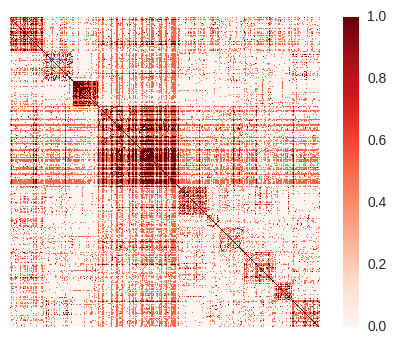

In [107]:
# plot affinity matrix

from sklearn.cluster import SpectralClustering
cluster = SpectralClustering(affinity='nearest_neighbors', n_clusters=10, n_neighbors=150, assign_labels='discretize')
cluster.fit(M_prop_pca.iloc[:,:50])
pat_affinity_matrix=pd.DataFrame(cluster.affinity_matrix_.todense(),index=M_prop_pca.index,columns=M_prop_pca.index)
pat2surv=pd.read_table('survival/pat2surv2labels.txt',index_col=0)
labels=pat2surv.loc[:,'K10']
pat_affinity_matrix=pd.concat([pat_affinity_matrix,labels],join='inner',axis=1).sort_values('K10')
pat_affinity_matrix=pd.concat([pat_affinity_matrix.T,labels],join='inner',axis=1).sort_values('K10')
pat_affinity_matrix=pat_affinity_matrix.drop('K10',axis=1)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.heatmap(pat_affinity_matrix,xticklabels=False, yticklabels=False,cmap='Reds',square=True)
plt.savefig('PatByPat_affinity_matrix.png', dpi=300)
plt.show()
pat_affinity_matrix[pat_affinity_matrix<0.5]=np.NAN

pat_affinity_matrix.stack().to_csv('affinity_matrix_stack.txt', sep='\t')

In [108]:
ttest_fdr_cut=0.3
fisher_p_cut=0.05

for subtype in range(10):
    print subtype
    essential_genes=set()
    gene2info={}
    for line in open('network/subtype_{}.noa'.format(subtype)).read().splitlines()[1:]:
        a=line.split('\t')
        ttest_fdr=float(a[3])
        fisher_p=float(a[4])
        if ttest_fdr<=ttest_fdr_cut:
            if fisher_p<=fisher_p_cut:
                essential_genes.add(a[0])
            gene2info[a[0]]=[ttest_fdr,fisher_p]
    header=True
    line_out=set()
    gene2line={}
    for line in open('network/subtype_{}.txt'.format(subtype)).read().splitlines():
        if header:
            line_header=line+'\n'
            header=False
            continue
        a=line.split('\t')
        if (a[0] in essential_genes) and (a[1] in essential_genes):
            line_out.add(line)
        elif a[0] in essential_genes:
            if a[1] not in gene2line:
                gene2line[a[1]]=set()
            gene2line[a[1]].add(line)
        elif a[1] in essential_genes:
            if a[0] not in gene2line:
                gene2line[a[0]]=set()
            gene2line[a[0]].add(line)
    for gene in gene2line:
        if len(gene2line[gene])>1:
            for line in gene2line[gene]:
                line_out.add(line)
    open('network/subtype_{}_dist1.txt'.format(subtype),'wb').write(line_header+'\n'.join(line_out)+'\n'+
                                                                    '\n'.join(essential_genes))

0
1
2
3
4
5
6
7
8
9


# Scratch

In [50]:
pca_components.loc['PC25',].sort_values()

GNAS       -0.269162
MASP1      -0.195420
RB1        -0.177179
PLCL1      -0.172300
MDM4       -0.165601
NRAS       -0.156684
BRCA2      -0.148157
SF3B1      -0.139068
GATA3      -0.112627
KCNJ5      -0.111269
NFE2L2     -0.109328
UQCRH      -0.101081
MET        -0.094014
APC        -0.090913
NCOA3      -0.089439
FOXJ3      -0.084932
IDH2       -0.083791
SKP2       -0.079676
ASXL1      -0.073474
PDGFRA     -0.070655
IDH1       -0.070428
KIT        -0.066866
CDKN2A     -0.065048
TARS2      -0.063498
GNAQ       -0.062875
DNMT3A     -0.061988
HRAS       -0.059441
CRTC3      -0.057554
STAG2      -0.053122
MPL        -0.051881
              ...   
RBL2        0.057367
HSPA6       0.063913
TRPC5       0.065323
FCGR2C      0.069759
PEX19       0.070892
RET         0.072321
KIF1B       0.073590
STK11       0.076579
BCOR        0.079144
FST         0.079595
MAP3K1      0.079772
GSTT2       0.082756
CREBBP      0.085048
PBRM1       0.091927
AES         0.097235
ZNF561      0.097435
PIK3R1      0

In [8]:
from sklearn.cluster import SpectralClustering
from multiprocessing import Pool

def run_SpectralClustering(args):
    [propagated_profile_pca, n_clusters, gamma] = args[:3]
    cluster = SpectralClustering(affinity='nearest_neighbors', n_clusters=n_clusters, n_init=10, 
                                 n_neighbors=n_neighbors, assign_labels=assign_labels)
    cluster.fit(propagated_profile_pca)
    return cluster.labels_

def run_clustering_mp(propagated_profile_pca, maxK, func, n_neighbors, assign_labels):

    n_processes = maxK-1
    pool = Pool(processes=n_processes)
    
    args = zip([propagated_profile_pca]*(maxK-1),range(2,maxK+1), [n_neighbors]*(maxK-1),[assign_labels]*(maxK-1))
    labels = pool.map(func, args)
    
    labels = pd.DataFrame(data=np.array(labels).T,index=propagated_profile_pca.index,
                          columns=['K{}'.format(i) for i in range(2,maxK+1)])
    
    pool.close()
    pool.join()
    
    return labels

for rst_prob in [0.5,0.4]:
    network_output_dir = 'FI_prop'
    PPR = np.load('{}/ppr_{}.npy'.format(network_output_dir,rst_prob))
    pat_diff = nbs.run_diffusion_PPR(PPR,mutation_profile)

    output_dir = network_output_dir
    # write propagated network on hard disk
    with open('{}/prop_pat_mut.npy'.format(output_dir),'w') as file_handle:
        np.save(file_handle,pat_diff)

    M_prop = np.load('FI_prop/prop_pat_mut.npy')
    with open('FI_prop/index_genes') as file_handle:
        genes = [a[1] for a in [line.split() for line in file_handle.read().splitlines()]]
    with open('FI_prop/index_patients') as file_handle:
        pats = [a[1] for a in [line.split() for line in file_handle.read().splitlines()]]
    M_prop=pd.DataFrame(data=M_prop,index=pats,columns=genes)
    
    M_prop_pca, pca_components, explained_variance_ratio = nbs.run_pca(M_prop)
    for nPCs in [50,70,100]:
        propagated_profile_pca=M_prop_pca.iloc[:,:nPCs]
        for n_neighbors in [5,10,20,50,65,85,100,125,130,150,160,165,170,175,180,200]:
            for assign_labels in ['discretize']:
                cluster = SpectralClustering(affinity='nearest_neighbors', n_clusters=10, n_init=10, 
                                             n_neighbors=n_neighbors, assign_labels=assign_labels)
                cluster.fit(propagated_profile_pca)
                labels=cluster.labels_
                labels = pd.DataFrame(data=np.array(labels).T,index=propagated_profile_pca.index, columns=['K10'])
#                 labels = run_clustering_mp(propagated_profile_pca, 10, run_SpectralClustering, n_neighbors, 
#                                            assign_labels)
                pat2surv_fn='../pat2clin4surv.txt'
                output_dir='survival/'
                os.system( 'mkdir -p ' + output_dir )
                pat2surv = pd.read_table(pat2surv_fn,index_col=0)
                pat2surv = pd.concat([pat2surv,labels],join='inner',axis=1)
                pat2surv.to_csv('{}/pat2surv2labels.txt'.format(output_dir),sep='\t')
                os.system("Rscript label2coxph_simple.R {}".format(output_dir))
                score=1
                for line in open('survival/coxph_FTest_survey.txt').read().splitlines():
                    a=line.split('\t')
                    score=float(a[-1])
                print rst_prob,nPCs,n_neighbors, assign_labels,score

0.5 50 5 discretize 0.059723780294
0.5 50 10 discretize 0.11124940782
0.5 50 20 discretize 0.096067803853
0.5 50 50 discretize 0.00603874824817
0.5 50 65 discretize 0.0300780550643
0.5 50 85 discretize 0.00078479479213
0.5 50 100 discretize 0.00257009295974
0.5 50 125 discretize 0.000490369157581
0.5 50 130 discretize 0.000739372630693
0.5 50 150 discretize 0.000612675751755
0.5 50 160 discretize 0.000470760545753
0.5 50 165 discretize 0.000429903929332
0.5 50 170 discretize 5.44486304097e-05
0.5 50 175 discretize 0.00747779576872
0.5 50 180 discretize 0.000855590041677
0.5 50 200 discretize 0.00011722221769
0.5 70 5 discretize 0.932137835135
0.5 70 10 discretize 0.107486156195
0.5 70 20 discretize 0.0945423223506
0.5 70 50 discretize 0.0236283964103
0.5 70 65 discretize 0.00602397977398
0.5 70 85 discretize 0.00166884722406
0.5 70 100 discretize 0.00587807182374
0.5 70 125 discretize 0.000683403880041
0.5 70 130 discretize 0.00161677223767
0.5 70 150 discretize 0.000371047140976
0.5 7

In [32]:
os.system("Rscript label2coxph.R survival/")

0

In [13]:
from sklearn.cluster import SpectralClustering
cluster = SpectralClustering(affinity='nearest_neighbors', n_clusters=10, n_neighbors=175, assign_labels='discretize')
cluster.fit(M_prop_pca.iloc[:,:100])
pat_affinity_matrix=pd.DataFrame(cluster.affinity_matrix_.todense(),index=M_prop_pca.index,columns=M_prop_pca.index)
labels = pd.DataFrame(data=np.array(cluster.labels_).T,index=M_prop_pca.index,columns=['K10'])
pat_affinity_matrix=pd.concat([pat_affinity_matrix,labels],join='inner',axis=1).sort_values('K10')
pat_affinity_matrix=pd.concat([pat_affinity_matrix.T,labels],join='inner',axis=1).sort_values('K10')
pat_affinity_matrix=pat_affinity_matrix.drop('K10',axis=1)

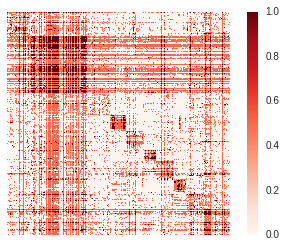

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.heatmap(pat_affinity_matrix,xticklabels=False, yticklabels=False,cmap='Reds',square=True)

# NBS based only on coding

In [ ]:
fn = 'pat2mut.txt'